<a href="https://colab.research.google.com/github/zimbit78/IAA2_Jalon1/blob/main/Jalon1_Thomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install contractions

In [77]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions

import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 1. Exploration du jeu de données

In [3]:
DATASET_FILE = "./dataset.csv"

In [4]:
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1
...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5
24996,Stopped here for a bite while wandering around...,5
24997,"A quiet place with excellent food, great music...",5
24998,Super delicious food. Awesome vibe. I suffered...,5


## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [5]:
stars_columns = dataset_df.stars
stars_columns

0        1
1        1
2        1
3        1
4        1
        ..
24995    5
24996    5
24997    5
24998    5
24999    5
Name: stars, Length: 25000, dtype: int64

In [6]:
stars_columns.value_counts()

5    5000
4    5000
3    5000
2    5000
1    5000
Name: stars, dtype: int64

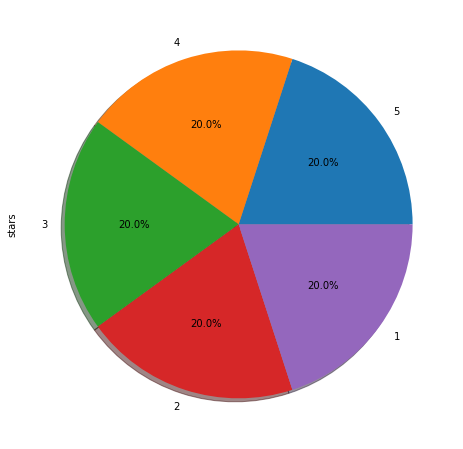

In [7]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [8]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41


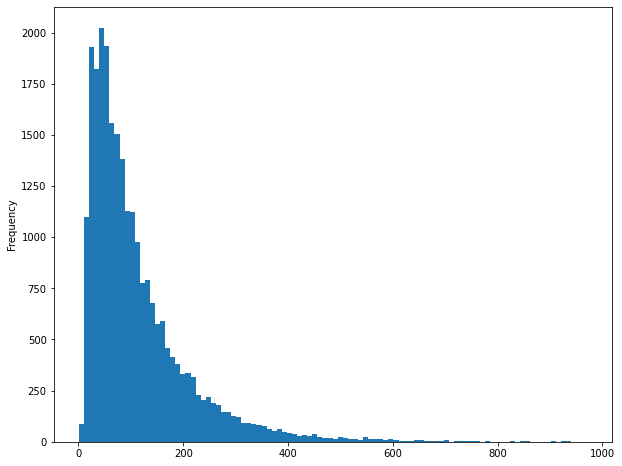

In [9]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8))

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

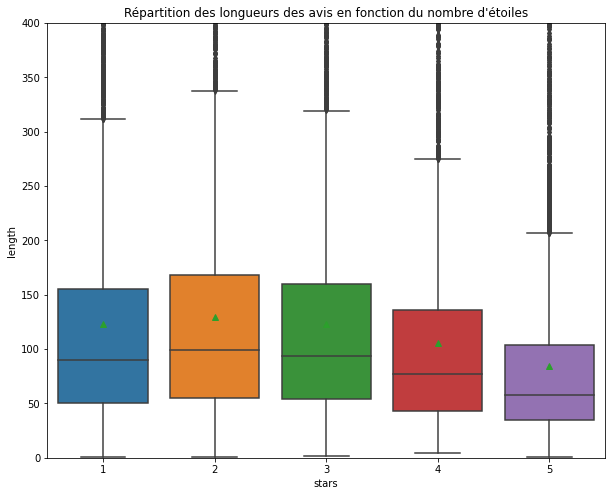

In [10]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars ,
            y=dataset_df.length,
            showmeans=True,
            )
ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

In [16]:
#tokennization
#contractions
#lowercase
#stemming / Lemming
#stopword

In [116]:
def tokenify(my_string) :
  sentence_endings = r"[.,?!]"
  phrase = " ".join(re.split(sentence_endings,my_string))

  spaces = r"\s+"
  token = re.split(spaces, phrase)

  token = [t for t in token if t != '']
  token = [t for t in token if not t.isdigit()]
  return token


In [133]:
def expand(tokens) :
  expanded_words = []   
  for word in tokens:
    # using contractions.fix to expand the shotened words
    expanded_words.append(contractions.fix(word))
  expanded_words = " ".join(expanded_words).split()
  expanded_words = [t.lower() for t in expanded_words]
  return expanded_words

In [183]:
from collections import Counter

def freq_words(text, n=10):
  """
  Return :- Most frequent words
  Input :- string
  Output :-
  """
  counter = Counter()
  # tokenization
  tokens = tokenify(text)
  for word in tokens:
    counter[word] = counter[word]+ 1

  FrequentWords = []
  # take top 10 frequent words
  for (word, word_count) in counter.most_common(n):
    FrequentWords.append(word)

  return FrequentWords

corpus = " ".join(dataset_df['text'].values).lower()
most_freq = freq_words(corpus,50)
print(most_freq)

['the', 'and', 'a', 'i', 'to', 'was', 'of', 'it', 'for', 'is', 'in', 'we', 'but', 'that', 'my', 'with', 'this', 'not', 'on', 'food', 'they', 'had', 'were', 'you', 'have', 'good', 'at', 'so', 'place', 'be', 'are', 'as', 'there', 'our', 'like', 'just', 'very', 'if', 'out', 'service', 'all', 'great', 'here', 'me', 'one', 'get', 'when', 'time', 'their', 'back']


In [181]:
def not_management(tokens):
  while 'not' in tokens :
    i = tokens.index('not')
    tokens.remove('not')
    if len(tokens) > i :
      tokens[i] = 'NOT_'+tokens[i]
    else :
      tokens[-1] = 'NOT_'+tokens[-1]
  while 'never' in tokens :
    i = tokens.index('never')
    tokens.remove('never')
    if len(tokens) > i :
      tokens[i] = 'NOT_'+tokens[i]
    else :
      tokens[-1] = 'NOT_'+tokens[-1]
  return tokens

def stop_wrd(tokens, most_freq = None) :
  stop_words = set(stopwords.words('english'))
  filtered_sentence = [w for w in tokens if not w in stop_words]
  if most_freq != None :
    filtered_sentence = [w for w in filtered_sentence if not w in most_freq]
  return filtered_sentence

In [113]:
def lemmatization(tokens) :
  lemmatizer = WordNetLemmatizer()
  token_tag = nltk.pos_tag(tokens)
  lemm_tokens = []
  for word, tag in token_tag :
    if tag.startswith('J'):
      lemm_tokens.append(lemmatizer.lemmatize(word,'a'))
    elif tag.startswith('V'):
      lemm_tokens.append(lemmatizer.lemmatize(word,'v'))
    elif tag.startswith('N'):
      lemm_tokens.append(lemmatizer.lemmatize(word,'n'))
    elif tag == 'PRP' :
      lemm_tokens.append(word)
    elif tag.startswith('R'):
      lemm_tokens.append(lemmatizer.lemmatize(word,'r'))
    else :
      lemm_tokens.append(lemmatizer.lemmatize(word))
  return lemm_tokens

In [150]:
def text_process (sentence, most_freq = None):
  return lemmatization(stop_wrd(not_management(expand(tokenify(sentence))), most_freq))


In [187]:
tps = []
for i,sentence in enumerate(dataset_df['text'].values) :
  if i*100/len(dataset_df['text'].values) % 10 == 0 :
    print(i*100/len(dataset_df['text'].values), '%')
  tps.append(" ".join(text_process(sentence, most_freq)))

dataset_df['tokens'] = tps

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


In [189]:
dataset_df.to_csv('./dataset_tokens.csv')